<a href="https://colab.research.google.com/github/MongiBESBES/Energy/blob/main/Copie_de_Analyse_6_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving dataset500.xlsx to dataset500 (1).xlsx


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [ ]:
# Chargez les données depuis le fichier Excel
file_path = '/content/dataset500.xlsx'
df = pd.read_excel(file_path)

# Assurez-vous que la colonne YEAR est de type datetime
df['date'] = pd.to_datetime(df['YEAR'], format='%y%m%d')

# Utilisez la colonne 'date' comme index
df.set_index('date', inplace=True)

# Choisissez la colonne 'GHI' comme variable cible
target_column = 'GHI'
ghi_values = df[target_column].values.reshape(-1, 1)

# Normalisez les valeurs entre 0 et 1
scaler = MinMaxScaler(feature_range=(0, 1))
ghi_scaled = scaler.fit_transform(ghi_values)

# Créez la série temporelle avec des séquences d'entrée et de sortie
def create_time_series(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
# Définissez la taille de la fenêtre temporelle (look_back)
look_back = 30

# Créez la série temporelle
X, y = create_time_series(ghi_scaled, look_back)

# Divisez les données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshapez pour le format d'entrée LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError, MeanAbsolutePercentageError

# Construisez le modèle GRU
model = Sequential()
model.add(GRU(50, input_shape=(look_back, 1), kernel_initializer='glorot_uniform'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), MeanSquaredError(), RootMeanSquaredError(), MeanAbsolutePercentageError()])


# Entraînez le modèle sur les données d'entraînement avec validation sur les données de validation
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

# Évaluez le modèle sur les données de test
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss on test set: {loss}')

# Effectuez des prédictions sur les données de test
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50
182/182 - 7s - loss: 0.0345 - mean_absolute_error: 0.1281 - mean_squared_error: 0.0345 - root_mean_squared_error: 0.1859 - mean_absolute_percentage_error: 102723.0156 - val_loss: 0.0139 - val_mean_absolute_error: 0.0857 - val_mean_squared_error: 0.0139 - val_root_mean_squared_error: 0.1179 - val_mean_absolute_percentage_error: 18.7919 - 7s/epoch - 37ms/step
Epoch 2/50
182/182 - 3s - loss: 0.0148 - mean_absolute_error: 0.0879 - mean_squared_error: 0.0148 - root_mean_squared_error: 0.1216 - mean_absolute_percentage_error: 74289.1953 - val_loss: 0.0131 - val_mean_absolute_error: 0.0796 - val_mean_squared_error: 0.0131 - val_root_mean_squared_error: 0.1144 - val_mean_absolute_percentage_error: 18.4620 - 3s/epoch - 14ms/step
Epoch 3/50
182/182 - 3s - loss: 0.0145 - mean_absolute_error: 0.0873 - mean_squared_error: 0.0145 - root_mean_squared_error: 0.1206 - mean_absolute_percentage_error: 63714.2930 - val_loss: 0.0137 - val_mean_absolute_error: 0.0892 - val_mean_squared_error: 0.0

In [ ]:
# Récupérez les dates correspondant aux données de test
test_dates = df.index[-len(y_test):]

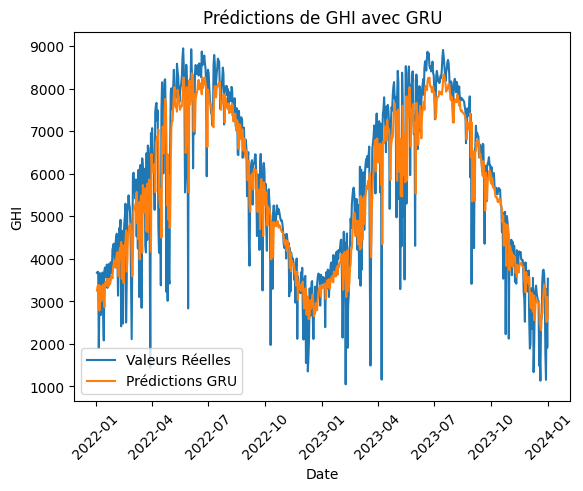

In [ ]:
plt.plot(test_dates, y_test, label='Valeurs Réelles')
plt.plot(test_dates, test_predict, label='Prédictions GRU')
plt.title('Prédictions de GHI avec GRU')
plt.xlabel('Date')
plt.ylabel('GHI')
plt.legend()
plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.show()


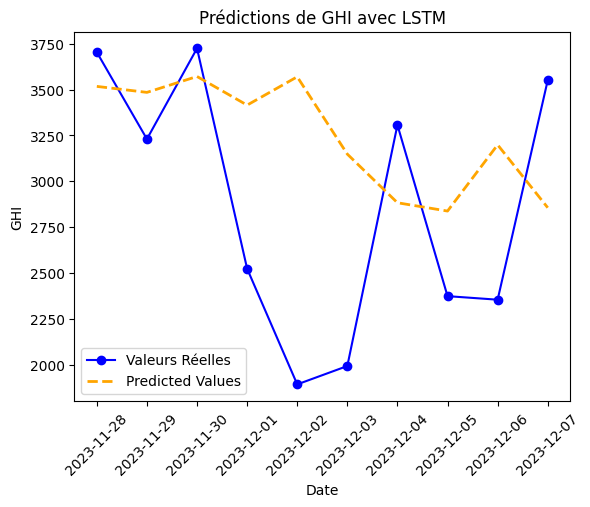

In [ ]:
def plot_random_predictions(test_dates, y_test, test_predict):
    # Sélectionner une date aléatoire 35 jours avant la fin des dates de test
    random_date_index = len(test_dates) - 35
    random_date = test_dates[random_date_index]

    # Trouver l'index de la date aléatoire dans les dates de test
    random_date_index_test = np.where(test_dates == random_date)[0][0]

    # Extraire les 10 valeurs réelles qui suivent la date aléatoire
    y_test_values = y_test[random_date_index_test + 1:random_date_index_test + 11]

    # Extraire les valeurs prédites associées (en ajustant l'indice)
    test_predict_values = test_predict[random_date_index_test:random_date_index_test + 10]

    # Déballer la dimension supplémentaire dans test_predict_values
    test_predict_values = np.squeeze(test_predict_values, axis=-1)

    # Plot des résultats
    plt.plot(test_dates[random_date_index_test + 1:random_date_index_test + 11], y_test_values,
             label='Valeurs Réelles', color='blue', marker='o')
    plt.plot(test_dates[random_date_index_test + 1:random_date_index_test + 11], test_predict_values,
             label='Predicted Values', color='orange', linestyle='dashed', linewidth=2)

    plt.title('Prédictions de GHI avec LSTM')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    plt.legend()

    # Rotation des étiquettes de l'axe des x
    plt.xticks(rotation=45)

    plt.show()

# Utilisation de la fonction
plot_random_predictions(test_dates, y_test, test_predict)


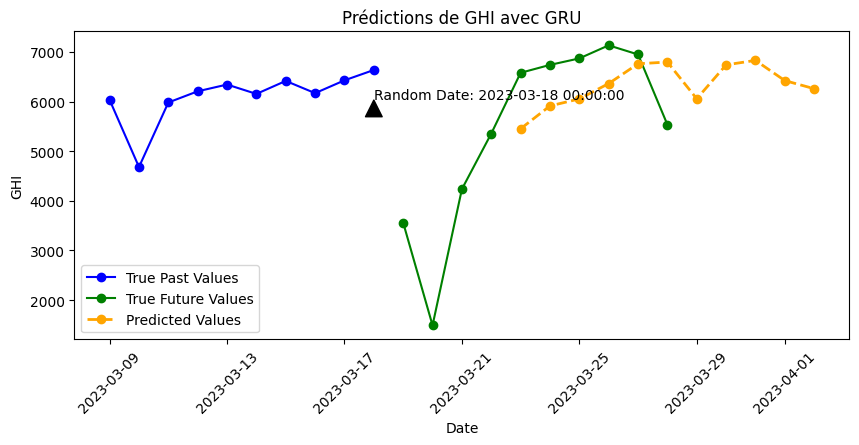

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_predictions(test_dates, y_test, test_predict, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    # Sélectionner une date aléatoire 35 jours avant la fin des dates de test
    random_date_index = np.random.choice(len(test_dates) - 35, size=1)[0]
    random_date = test_dates[random_date_index]

    # Trouver l'index de la date aléatoire dans les dates de test
    random_date_index_test = np.where(test_dates == random_date)[0][0]

    # Extraire les 10 valeurs réelles qui suivent la date aléatoire (True past values + True future values)
    true_past_values = y_test[random_date_index_test - 9:random_date_index_test + 1]
    true_future_values = y_test[random_date_index_test + 1:random_date_index_test + 11]

    # Extraire les 10 valeurs prédites associées (True future values + 5 valeurs prédites avant + 5 valeurs prédites après)
    test_predict_values = test_predict[random_date_index_test +5:random_date_index_test + 16]

    # Déballer la dimension supplémentaire dans test_predict_values
    test_predict_values = np.squeeze(test_predict_values, axis=-1)


    # Créer une nouvelle figure avec une taille personnalisée (par exemple, largeur=12, hauteur=6)
    plt.figure(figsize=(10, 4))


    # Plot des résultats
    plt.plot(test_dates[random_date_index_test - 9:random_date_index_test + 1], true_past_values,
             label='True Past Values', color='blue', marker='o')
    plt.plot(test_dates[random_date_index_test + 1:random_date_index_test + 11], true_future_values,
             label='True Future Values', color='green', marker='o')
    plt.plot(test_dates[random_date_index_test +5:random_date_index_test + 16], test_predict_values,
             label='Predicted Values', color='orange', linestyle='dashed', linewidth=2, marker='o')

    # Ajouter une annotation pour indiquer la date aléatoire
    plt.annotate(f'Random Date: {random_date}',
                 xy=(random_date, true_past_values[0]),
                 xytext=(random_date, true_past_values[0] + 10),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 )

    plt.title('Prédictions de GHI avec GRU')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    plt.legend()

    # Rotation des étiquettes de l'axe des x
    plt.xticks(rotation=45)

    plt.show()

# Utilisation de la fonction
plot_random_predictions(test_dates, y_test, test_predict)


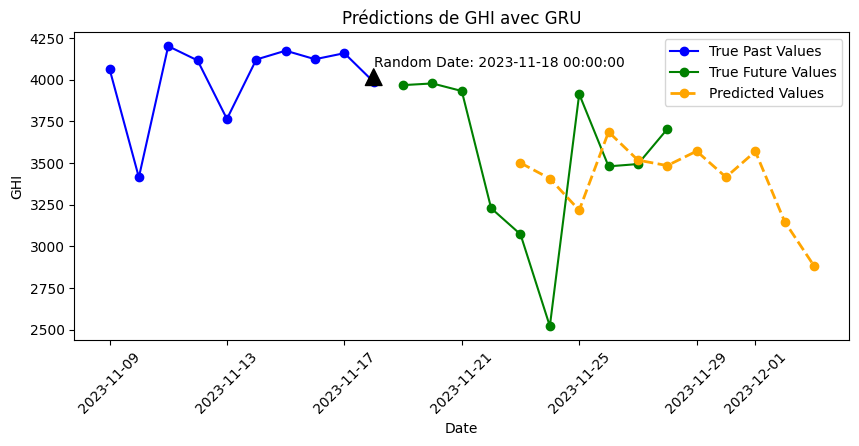

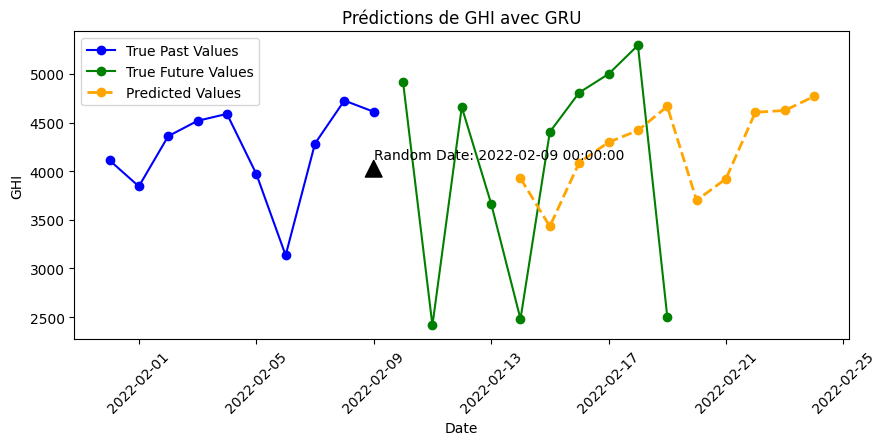

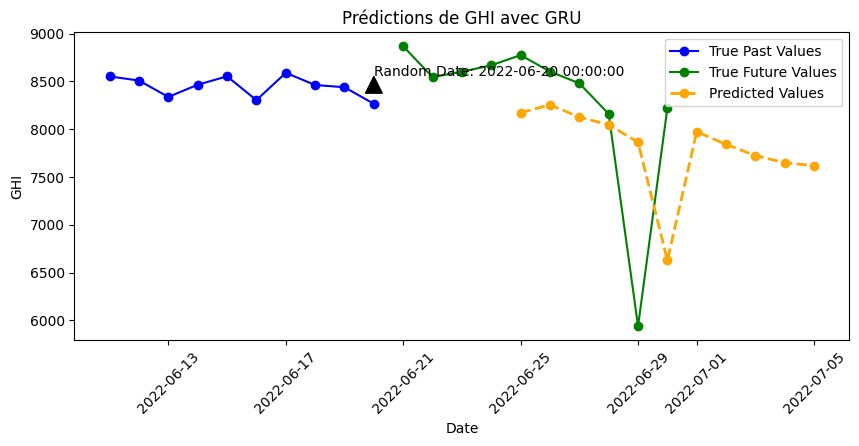

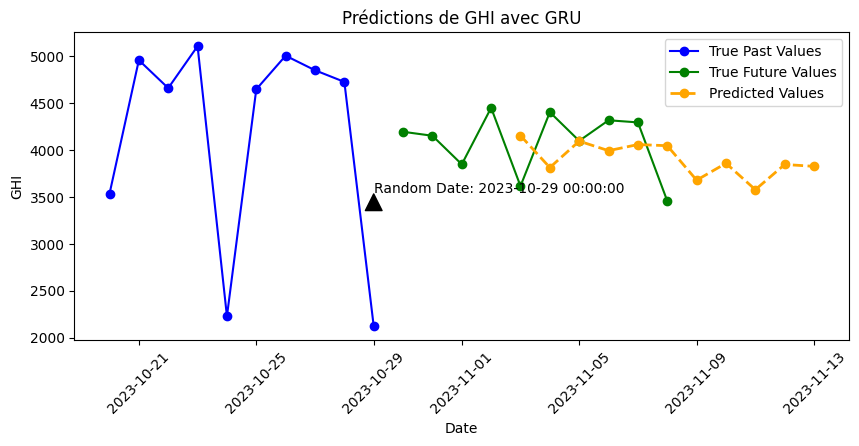

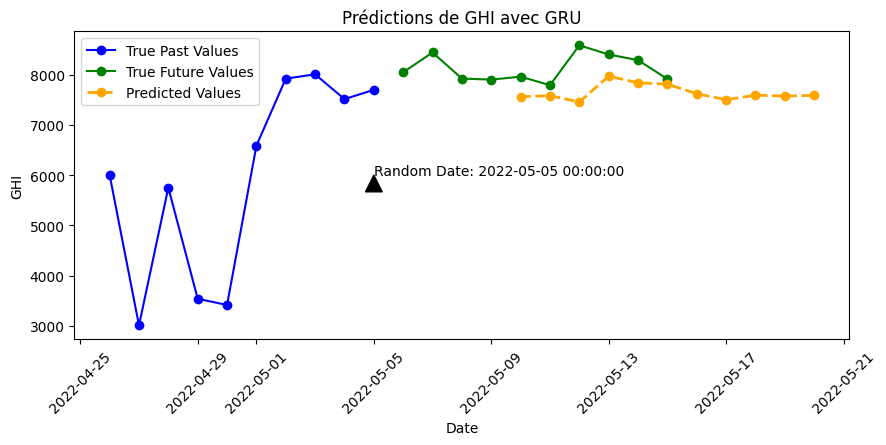

In [ ]:
# Utilisation de la fonction plusieurs fois avec différentes dates aléatoires
for i in range(5):
    plot_random_predictions(test_dates, y_test, test_predict, random_seed=i)

In [ ]:
# Évaluez le modèle sur les données de test
loss, mae, mse, rmse, mape = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss on test set: {loss}')
print(f'Mean Absolute Error on test set: {mae}')
print(f'Mean Squared Error on test set: {mse}')
print(f'Root Mean Squared Error on test set: {rmse}')
print(f'Mean Absolute Percentage Error on test set: {mape}')

Loss on test set: 36682168.0
Mean Absolute Error on test set: 5714.16943359375
Mean Squared Error on test set: 36682168.0
Root Mean Squared Error on test set: 6056.58056640625
Mean Absolute Percentage Error on test set: 99.98918151855469


In [ ]:
from sklearn.metrics import r2_score

# ... (votre code pour construire, entraîner et évaluer le modèle)

# Effectuez des prédictions sur les données de test
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculer R²
r2 = r2_score(y_test, test_predict)
print(f'R² on test set: {r2}')

23/23 [==============================] - 0s 5ms/step
R² on test set: -8.099730609989379


In [ ]:
import numpy as np
from scipy.stats import pearsonr

# Fonction pour calculer MSLE et MALE
def calculate_logarithmic_errors(y_true, y_pred):
    msle = np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)
    male = np.mean(np.abs(np.log1p(y_true) - np.log1p(y_pred)))
    return msle, male

# Fonction pour calculer MPE
def calculate_mean_percentage_error(y_true, y_pred):
    mpe = np.mean((y_true - y_pred) / y_true) * 100
    return mpe

# Exemple d'utilisation des fonctions
y_true = np.array([2, 3, 5, 7, 11])
y_pred = np.array([1.8, 3.2, 4.8, 7.2, 10.5])

# Calcul des MSLE et MALE
msle, male = calculate_logarithmic_errors(y_true, y_pred)
print(f'MSLE: {msle}')
print(f'MALE: {male}')

# Calcul du coefficient de corrélation de Pearson
pearson_coefficient, _ = pearsonr(y_true, y_pred)
print(f'Coefficient de Pearson : {pearson_coefficient}')

# Calcul de MPE
mpe = calculate_mean_percentage_error(y_true, y_pred)
print(f'MPE: {mpe}')

MSLE: 0.0021421715075457554
MALE: 0.04378736286824649
Coefficient de Pearson : 0.9971044736360464
MPE: 1.8043290043290032
